# Imports

In [1]:
#Imports
%matplotlib widget
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import scipy
import datetime
import networkx as nx
import misc
import math
import random
import SmallBucket
import BigBucket
import RandomWarmUp1
import RandomWarmUp2
import StaticDynamic
import DcOrient

# Data Generation

In [2]:
G = misc.createRandomGraph(size=182, variation=0, density=0.267, maxDegree=67)
misc.graphInfo(G)

Nodes: 182
Edges: 4397
Density: 0.26695404043470344
Max Degree: 67
Average Degree: 48.31868131868132
Static Coloring uses 19 colors


In [3]:
updates = misc.extractUpdates(G, 'random')

In [4]:
Ge = nx.Graph()
Ge.add_nodes_from(list(G.nodes()))

# Algorithm Preparation

In [5]:
experimentList = []

experimentList.append((SmallBucket.SmallBucketAlgo(5, Ge), 'Small-Bucket algorithm with d = 5'))
experimentList.append((BigBucket.BigBucketAlgo(5, Ge), 'Big-Bucket algorithm with d = 5'))
experimentList.append((StaticDynamic.StaticDynamicAlgo(Ge, 5, dynamicReset=False), 'Static-Dynamic algorithm with l = 5'))
experimentList.append((RandomWarmUp1.WarmUp1Algo(Ge, maxDegreeBound=None), 'Random Warm-Up 1 without max degree'))
experimentList.append((RandomWarmUp2.WarmUp2Algo(Ge, maxDegreeBound=None), 'Random Warm-Up 2 without max degree'))
experimentList.append((DcOrient.DcOrientAlgo(Ge), 'DC-Orient'))

# Experimenting

In [6]:
print('Graph used in the experiment:')
misc.graphInfo(G)

for experiment in experimentList:

    print("")
    print("------------------------------------------------------------------")
    print(str(experiment[1]) + ":")
    iterator = misc.UpdateIterator(experiment[0], updates)

    recolors = 0

    while True:
        if not misc.verifyColoring(iterator.algo.G, iterator.algo.getColoring()):
            raise ValueError('The coloring produced is incorrect')
        c1 = iterator.algo.getColoring()
        if iterator.runUpdate(1):
            c2 = iterator.algo.getColoring()
            recolors += misc.numberOfRecolors(c1, c2)
        else:
            #print("all updates finished")
            break

    print("")
    print("Average number of recolors per update: " + str(float(recolors)/len(updates)))
    print("Total number of colors used at the end: " + str(misc.numberOfColors(iterator.algo.getColoring())))
    print("------------------------------------------------------------------")

print("End of experiment list reached")



Graph used in the experiment:
Nodes: 182
Edges: 4397
Density: 0.26695404043470344
Max Degree: 67
Average Degree: 48.31868131868132
Static Coloring uses 19 colors
------------------------------------------------------------------
Small-Bucket algorithm with d = 5:

Average number of recolors per update: 3.8414828292017282
Total number of colors used at the end: 21
------------------------------------------------------------------
------------------------------------------------------------------
Big-Bucket algorithm with d = 5:

Average number of recolors per update: 4.830338867409598
Total number of colors used at the end: 20
------------------------------------------------------------------
------------------------------------------------------------------
Static-Dynamic algorithm with l = 5:

Average number of recolors per update: 1.7471002956561292
Total number of colors used at the end: 104
------------------------------------------------------------------
-------------------------

# Results

In [7]:
print("Average number of recolors per update: " + str(float(recolors)/len(updates)))
print("Total number of colors used at the end: " + str(misc.numberOfColors(iterator.algo.getColoring())))

Average number of recolors per update: 15.232886058676371
Total number of colors used at the end: 19


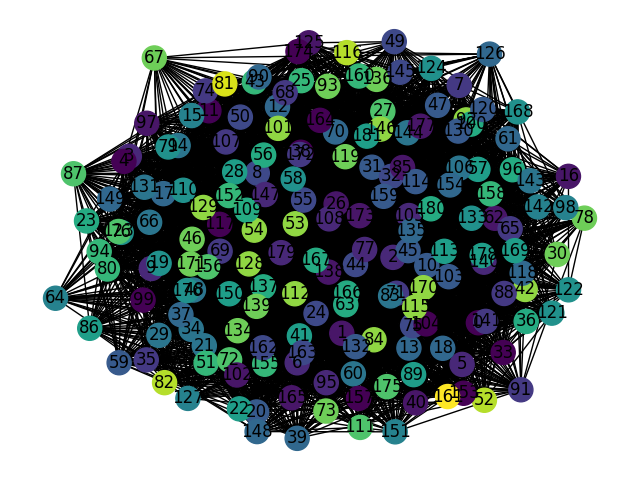

True


In [8]:
misc.draw(iterator.algo.G, iterator.algo.getColoring())
print(misc.verifyColoring(iterator.algo.G, iterator.algo.getColoring()))